In [13]:
import argparse
import datetime
import numpy as np
import time
import torch
import torch.backends.cudnn as cudnn
import json
import os

from pathlib import Path

from timm.models import create_model
from optim_factory import create_optimizer

from datasets import build_beit_pretraining_dataset
from engine_for_pretraining import train_one_epoch
from utils import NativeScalerWithGradNormCount as NativeScaler
import utils
import modeling_pretrain
import modeling_vqkd
import modeling_finetune as model
import optim_factory as optim

Dataset:

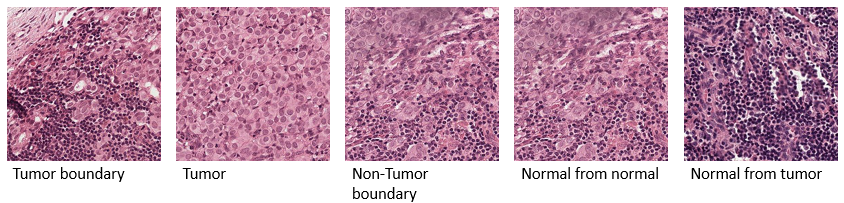

Total Images: 20547 

BEIT Structure:

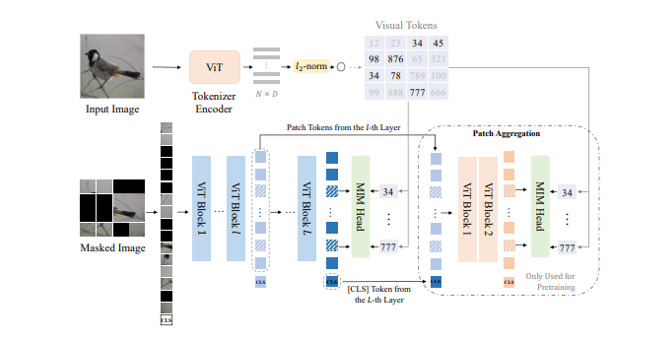

Part-1: VQ-KD training

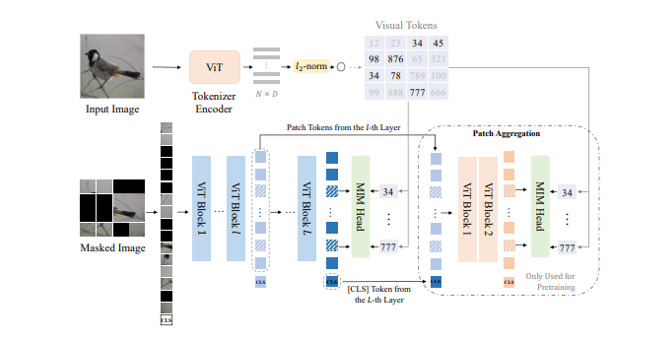

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=8 run_vqkd_training.py --data_set train_images_lv2 --data_path D:/Project_591/Datasets/ --eval_data_path D:/Project_591/Datasets/ --output_dir D:/Project_591/Jupyter/output_vqkd --log_dir D:/Project_591/Jupyter/log_vqkd --process_type default --train_interpolation bicubic --min_crop_scale 0.08 --model vqkd_encoder_base_decoder_3x768x12_clip  --teacher_input_size 224  --codebook_n_emd 8192 --codebook_emd_dim 32 --quantize_kmeans_init --rec_loss_type cosine  --batch_size 64 --opt adamw  --opt_betas 0.9 0.99  --weight_decay 1e-4  --warmup_epochs 1  --epochs 1 --save_ckpt_freq 20 

Reconstruction Loss

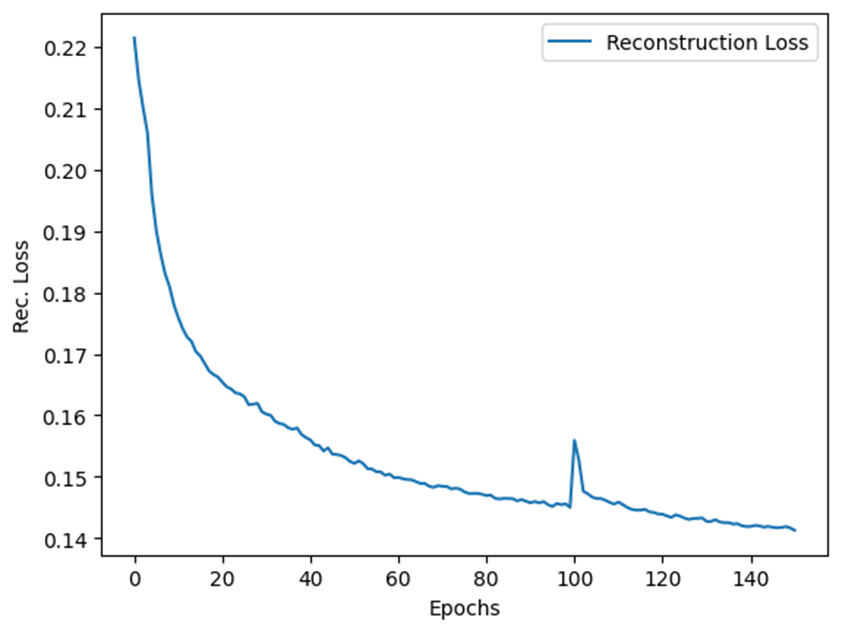

Codebook Usage

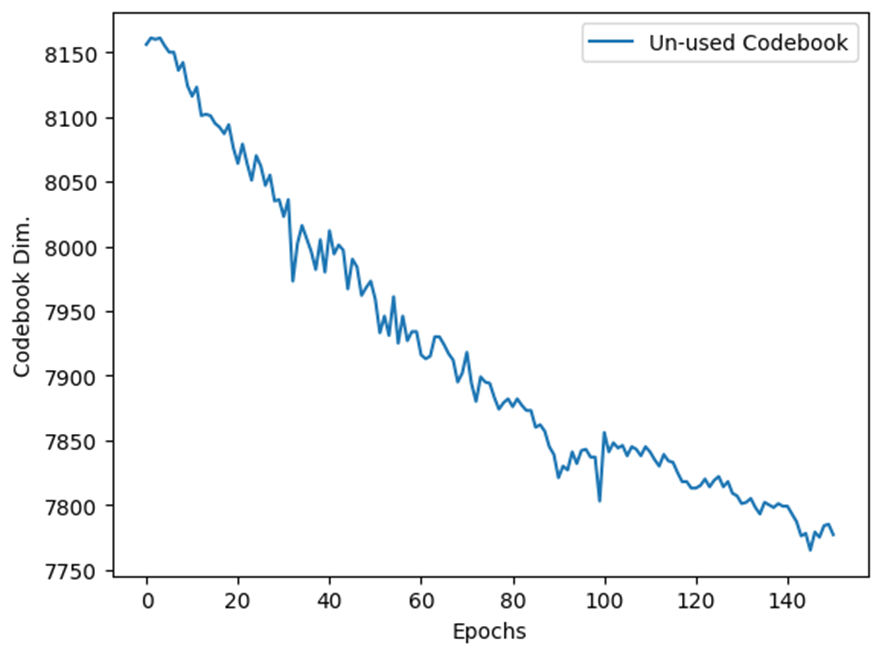

Part-2: BEIT Pre-Training

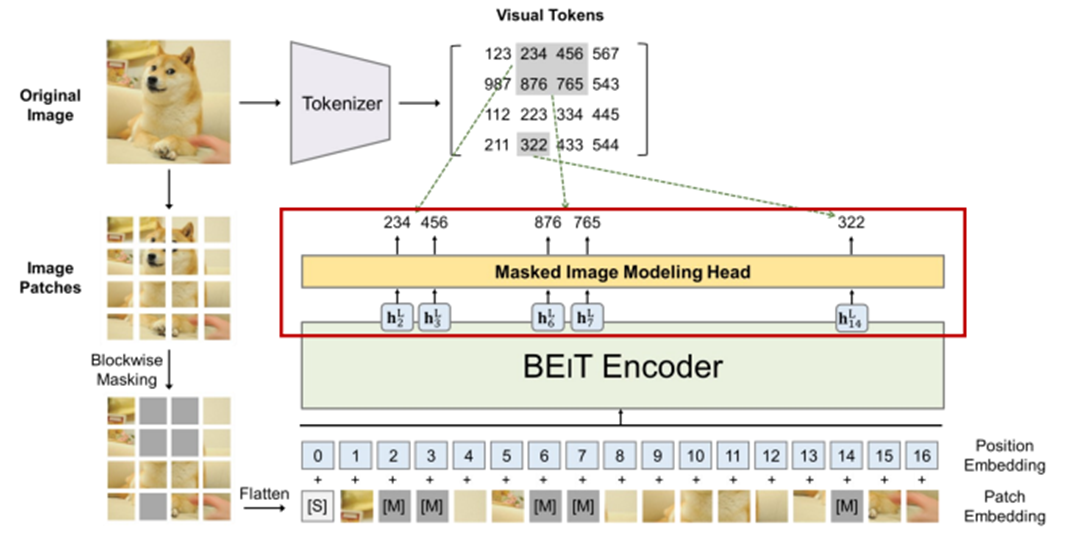

! python -m torch.distributed.launch --nproc_per_node=1 run_beitv2_pretraining.py --data_set image_folder --data_path D:/Project_591/vqkd_training  --output_dir D:/Project_591/beit_output --log_dir D:/Project_591/beit_log_output --model beit_base_patch16_224_8k_vocab_cls_pt --shared_lm_head True --early_layers 9 --head_layers 2 --num_mask_patches 75 --second_input_size 224 --second_interpolation bicubic --min_crop_scale 0.2 --tokenizer_model vqkd_encoder_base_decoder_3x768x12_clip --tokenizer_weight D:/Project_591/inter_model/checkpoint.pth --batch_size 24 --lr 1.5e-3 --warmup_epochs 10 --clip_grad 3.0 --drop_path 0.1 --layer_scale_init_value 0.1 --imagenet_default_mean_and_std --opt_betas 0.9 0.999 --opt_eps 1e-8  --epochs 417  --save_ckpt_freq 20

In [7]:
! python -m torch.distributed.launch --nproc_per_node=1 run_beitv2_pretraining.py --data_set image_folder --data_path D:/Project_591/vqkd_training  --output_dir D:/Project_591/beit_output --log_dir D:/Project_591/beit_log_output --model beit_base_patch16_224_8k_vocab_cls_pt --shared_lm_head True --early_layers 9 --head_layers 2 --num_mask_patches 75 --second_input_size 224 --second_interpolation bicubic --min_crop_scale 0.2 --tokenizer_model vqkd_encoder_base_decoder_3x768x12_clip --tokenizer_weight D:/Project_591/inter_model/checkpoint.pth --batch_size 24 --lr 1.5e-3 --warmup_epochs 10 --clip_grad 3.0 --drop_path 0.1 --layer_scale_init_value 0.1 --imagenet_default_mean_and_std --opt_betas 0.9 0.999 --opt_eps 1e-8  --epochs 722  --save_ckpt_freq 20

| distributed init (rank 0): env://, gpu 0
Namespace(batch_size=24, epochs=722, save_ckpt_freq=20, tokenizer_weight='D:/Project_591/inter_model/checkpoint.pth', tokenizer_model='vqkd_encoder_base_decoder_3x768x12_clip', model='beit_base_patch16_224_8k_vocab_cls_pt', rel_pos_bias=True, abs_pos_emb=False, layer_scale_init_value=0.1, num_mask_patches=75, max_mask_patches_per_block=None, min_mask_patches_per_block=16, input_size=224, second_input_size=224, drop_path=0.1, early_layers=9, head_layers=2, shared_lm_head=True, codebook_size=8192, codebook_dim=32, opt='adamw', opt_eps=1e-08, opt_betas=[0.9, 0.999], clip_grad=3.0, momentum=0.9, weight_decay=0.05, weight_decay_end=None, lr=0.0015, warmup_lr=1e-06, min_lr=1e-05, warmup_epochs=10, warmup_steps=-1, decoupling_aug=False, color_jitter=0.4, train_interpolation='bicubic', second_interpolation='bicubic', min_crop_scale=0.2, data_path='D:/Project_591/vqkd_training', eval_data_path='', data_set='image_folder', imagenet_default_mean_and_std=

NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\zafaryab.haider\Anaconda3\lib\site-packages\torch\distributed\launch.py:180: FutureWarning: The module torch.distributed.launch is deprecated
and will be removed in future. Use torchrun.
Note that --use_env is set by default in torchrun.
If your script expects `--local_rank` argument to be set, please
change it to read from `os.environ['LOCAL_RANK']` instead. See 
https://pytorch.org/docs/stable/distributed.html#launch-utility for 
further instructions

  warnings.warn(
[W C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\distributed\c10d\socket.cpp:601] [c10d] The client socket has failed to connect to [DTVF6S3.uad.maine.edu]:29500 (system error: 10049 - The requested address is not valid in its context.).
[W C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\distributed\c10d\socket.cpp:601] [c10d] The client socket has failed to connect to [DTVF6S3.uad.maine.edu]

BEIT Finetuning:

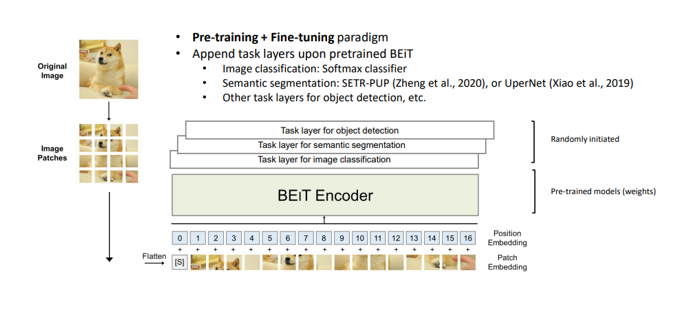

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 run_class_finetuning.py --data_path D:/Project_591/vqkd_training/train --eval_data_path D:/Project_591/vqkd_training/test --nb_classes 2 --data_set image_folder --output_dir D:/Project_591/classification_final_model_beit --log_dir D:/Project_591/classification_log_beit --model beit_base_patch16_224 --weight_decay 0.05 --finetune https://conversationhub.blob.core.windows.net/beit-share-public/beitv2/beitv2_base_patch16_224_pt1k_ft21k.pth --batch_size 24 --lr 5e-5 --update_freq 1 --warmup_epochs 20 --epochs 30 --layer_decay 0.75 --drop_path 0.1 --mixup 0. --cutmix 0. --imagenet_default_mean_and_std --dist_eval --save_ckpt_freq 20

In [57]:
from functools import partial
import torch.nn as nn
import run_class_finetuning as fine
from get_wirghts_from_checkpoint import load_weights_to_model 

In [108]:
m = fine.create_model(model_name='beit_base_patch16_224', pretrained=False,
        num_classes=2,
        drop_rate=0.0,
        drop_path_rate=0.1,
        attn_drop_rate=0.0,
        drop_block_rate=None,
        use_mean_pooling=True,
        init_scale=0.001,
        use_rel_pos_bias=True,
        use_abs_pos_emb=False,
        init_values=0.1,
        qkv_bias=True)

checkpoint=torch.load("D:\\Project_591\\classification_final_model_beit\\checkpoint-best.pth",map_location='cpu')
load_weights_to_model(m,checkpoint)
m.eval()



Load ckpt from 
Load state_dict by model_key = model
Ignored weights of VisionTransformer not initialized from pretrained model: ['blocks.0.attn.relative_position_index', 'blocks.1.attn.relative_position_index', 'blocks.2.attn.relative_position_index', 'blocks.3.attn.relative_position_index', 'blocks.4.attn.relative_position_index', 'blocks.5.attn.relative_position_index', 'blocks.6.attn.relative_position_index', 'blocks.7.attn.relative_position_index', 'blocks.8.attn.relative_position_index', 'blocks.9.attn.relative_position_index', 'blocks.10.attn.relative_position_index', 'blocks.11.attn.relative_position_index']


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): A

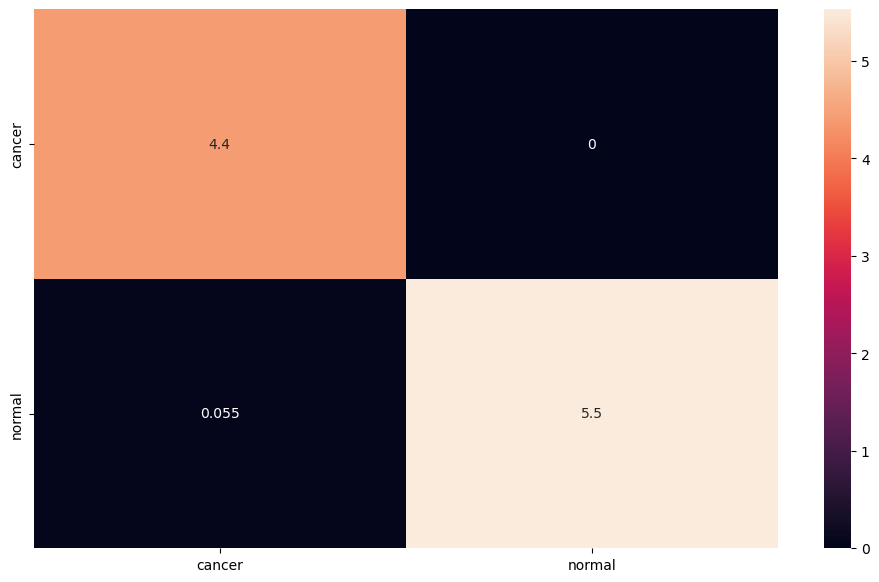

In [109]:
from evaluation_model import build_dataset_for_evaluation_confusion_matrix
build_dataset_for_evaluation_confusion_matrix(path="D:\\Project_591\\evaluate",model=m)